# DAML Project 2

Importing relevant libraries and useful functions (from notes)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from iminuit import Minuit
import iminuit
import scipy
from scipy import integrate

In [4]:
# Taken from the notes from many weeks ago to show iminuit results
def showIminuitResult( paramNames, theMinuit ):
    
    #averageList = {}

    fstr = "{0:8.4f}"
    for pn in paramNames :
        val = theMinuit.values[pn]
        err = theMinuit.errors[pn]
        print('\t','{:15s}'.format(pn), ':  \t', fstr.format(val), ' +/- ', fstr.format(err))
    print('\n')

## Part 1: Estimating statisical precision

Use the method of pseudo-experiments (toy Monte Carlo) to determine the expected statistical
precision with which one could measure each of the parameters with (i) 10,000 events and (ii)
100,000 events. Assume perfect detector-resolution/perfect time measurements.

The equation given for the relevant decay X -> D has the following PDF:
P proportional to (1 + Vsin(deltaM * t)) * exp(-t/tau) 

Can just make P = RHS and determine normalisation factor. Do this within a range of 0 to 10, rather than 1 to infinity, as the exponential component makes results beyond 10 mostly irrelevant (and the normalisation becomes a bit more difficult).

We need to build up the montecarlo simulation method to allow for precision determination in each of the parameters, tau, V and deltaM.

In [5]:
# Setting nominal values
tau = 1.5
V = 0.1
deltaM = 20.0

In [6]:
# define normalised probability density function

def decay_pdf(t, tau, V, deltaM):
    # calculated normalisation from range 0 to 10 for our probability equation
    # broke it up into parts, because otherwise it looks like a mess, and is really hard to read
    numerator = deltaM**2 * tau**2 + 1
    outer_denom = tau* np.exp(-10/tau)
    inner_denom = (deltaM**2 * tau**2 + V*deltaM*tau + 1)*np.exp(10/tau) - deltaM**2*tau**2 - V*deltaM*np.cos(10*deltaM)-V*np.sin(10*deltaM)-1
    norm = numerator/(outer_denom*inner_denom)
    # apply normalisation to pdf and return it
    pdf_val = norm*(1+V*np.sin(deltaM*t))*np.exp(-t/tau)
    return pdf_val

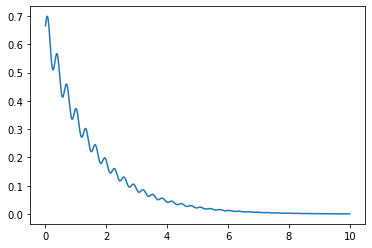

In [5]:
# Visualise the function (and to check its correct)
x_coords = np.linspace(0,10,num=1000)
y_coords = decay_pdf(x_coords, tau, V, deltaM)

plt.plot(x_coords,y_coords)
plt.show()

Plugged directly into desmos as well, looks exactly like this with the correct parameters.

Now create a box method for our PDF to create a random distribution of our function:

In [14]:
# Create a simulation function that scales to whatever value of values are needed, between 0 and upper limit
def box_sim(runs, tau, V, deltaM, upperlim):
        # Create list of pdf results
    pdf_list = []
        # Create values for upper and lower limits required by the box random generator
    l_limit = 0
    h_limit = 1
        # find f_max by taking exponent at maximum and multiplying by 1.1
        # 1.1 chosen arbitrarily as it makes it larger than max value of f
        # This could cause issues at larger V, which defines the sinusoidal amplitude.
        # So if the true 'max' value from the sinusoid is larger than 110% of the initial exponent position
        # This shouldnt come up here though as our V is small
    f_max = decay_pdf(0,tau, V, deltaM) * 1.1

        # Create N random muon decays across 10 microseconds
    while (len(pdf_list) < runs):
            # generate random number within our pdf range scale between 0 and our upperlimit (of 10)
        x1 = np.random.uniform(low = l_limit, high = h_limit*upperlim)
            # Apply our pdf
        y1 = decay_pdf(x1,tau, V, deltaM)
            # generate second random number scale between 0 and our f_max
        y2 = np.random.uniform(low = l_limit, high = h_limit*f_max)

            # Check if y2 < y1. If so, add to list
        if (y2 < y1):
            pdf_list.append(x1)
        else:
            continue;
            
    return pdf_list
   
        



Define the nll function for our PDF, and use minuit to fit our pdf function to our box-method data. The number of events will change the statistical precision given, but the statistical uncertainty given by minuit will give us the expected statistical precision we can measure each of our parameters with.

In [20]:
def nll_decay(tau, V, deltaM):
    
    # Take data, will need to define this before calling the function, which will be done if you run through the notebook linearly
    x = np.array(pdf_list)
    
    # calculate the pdf value, already normalised
    y = decay_pdf(x, tau, V, deltaM)
    
    # limit y so that is cant be zero here
    y = [10e-4 if y[i] <= 0 else y[i] for i in range(len(y))]
    
    # take log of y
    y_log = np.log(y)
    
    # take negative sum
    nll_sum = -np.sum(y_log)
    
    return nll_sum

Generating 10,000 event PDF data

In [8]:
# Run sim with upperlimit of 10, to create a starter 'PDF' for the 
pdf_list = box_sim(10000, tau, V, deltaM, 10)


In [12]:
# defining the plotting function used throughout the code
def plot_hist(title, pdf_list):
    # Print histogram of pdf_list and describe the results
    plt.title(title)
    plt.xlabel("Time (no unit)")
    plt.ylabel("Density")
    plt.hist(pdf_list, bins = 200, density = True)
    plt.show()
    

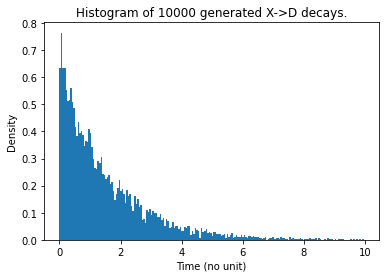

In [10]:
# and plotting our data
plot_hist("Histogram of 10000 generated X->D decays.", pdf_list)

Now to use minuit with the nll to determine the parameters from this PDF. Creating a basic minuit function that will be used throughout the code:

In [13]:
# Minuit automated function
def minuit_process(nll):

    # hardcode the errors, errordef, limits and parameter guess vals as they will be the same across the entire project
    m = Minuit(nll, tau = 1, V = 0.5, deltaM = 21)
    # Set errors
    m.errors = [1,1,2]
    # Define for NLL
    m.errordef = 0.5
    # Set limits
    m.limits = [[0,3], [0,2], [10,30]]
    
    # Fit and return fit
    result = m.migrad()
    
    return result



In [12]:
# Apply minuit and show results
m = minuit_process(nll_decay)
showIminuitResult(("tau","V","deltaM"), m)

	 tau             :  	   1.5084  +/-    0.0156
	 V               :  	   0.0958  +/-    0.0142
	 deltaM          :  	  20.0010  +/-    0.0621




And giving the statistical precision for our main parameters:

In [13]:
# Reformatting this
# {:.2} is significant digits (rounded to two)
print("Statistical Errors for 10000 events")
print("KEY   -   Value Name : Value(Expected statistical precision/error)\n")
print("Lifetime parameter (Tau) : {:.4}({:.2})".format(m.values["tau"],m.errors["tau"]))
print("Matter/A-Matter asymm parameter (V) : {:.4}({:.2})".format(m.values["V"],m.errors["V"]))
print("Mass difference parameter (deltaM) : {:.4}({:.2})".format(m.values["deltaM"],m.errors["deltaM"]))



Statistical Errors for 10000 events
KEY   -   Value Name : Value(Expected statistical precision/error)

Lifetime parameter (Tau) : 1.508(0.016)
Matter/A-Matter asymm parameter (V) : 0.09579(0.014)
Mass difference parameter (deltaM) : 20.0(0.062)


This shows the statistical precision of our 10000 event run for our three parameters (the brackets are the statistical precision).

Our true fit values are quite close to the true values as well, within 2 sigma (on this run at least).

Now to do the same for 100000 events, we dont need to consider the pdf_list as it is always updated before the fit is run

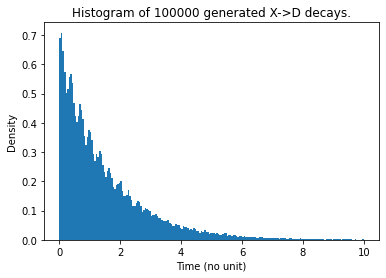

In [14]:
# 100,000 events
# Run sim with upperlimit of 10, to create a starter 'PDF' for the exponential
pdf_list = box_sim(100000, tau, V, deltaM, 10)


# plot histogram
plot_hist("Histogram of 100000 generated X->D decays.", pdf_list)


In [15]:
# Apply minuit and show results
n = minuit_process(nll_decay)
showIminuitResult(("tau","V","deltaM"), n)

	 tau             :  	   1.5005  +/-    0.0049
	 V               :  	   0.1090  +/-    0.0045
	 deltaM          :  	  20.0004  +/-    0.0197




And giving the statistical precision for our main parameters:

In [16]:
# Reformatting this

# {:.2} is significant digits (rounded to two)
print("Statistical Errors for 100000 events")
print("KEY   -   Value Name : Value(Expected statistical precision/error)\n")
print("Lifetime parameter (Tau) : {:.4}({:.2})".format(n.values["tau"],n.errors["tau"]))
print("Matter/A-Matter asymm parameter (V) : {:.4}({:.2})".format(n.values["V"],n.errors["V"]))
print("Mass difference parameter (deltaM) : {:.4}({:.2})".format(n.values["deltaM"],n.errors["deltaM"]))


Statistical Errors for 100000 events
KEY   -   Value Name : Value(Expected statistical precision/error)

Lifetime parameter (Tau) : 1.501(0.0049)
Matter/A-Matter asymm parameter (V) : 0.109(0.0045)
Mass difference parameter (deltaM) : 20.0(0.02)


So comparing the 10,000 and 100,000 statistical precision:

In [17]:
print("Statistical precision for 10,000 and 100,000")
print("Tau (10,000): {:.2}       Tau (100,000): {:.2}".format(m.errors["tau"],n.errors["tau"]))
print("V (10,000): {:.2}         V (100,000): {:.2}".format(m.errors["V"],n.errors["V"]))
print("deltaM (10,000): {:.2}    deltaM (100,000): {:.2}".format(m.errors["deltaM"],n.errors["deltaM"]))

Statistical precision for 10,000 and 100,000
Tau (10,000): 0.016       Tau (100,000): 0.0049
V (10,000): 0.014         V (100,000): 0.0045
deltaM (10,000): 0.062    deltaM (100,000): 0.02


So we can see here (understandably) that the more events we include, the better the statistical precision (the smaller the uncertainty given by the statistical error inherent in our data distribution).

Understandably, this statistical precision is able to change due to the random nature of our data production method. A way to solve this would be to run the 10,000 events multiple times to determine a bias and average for our parameters.

In [7]:
# Create a function that will automaticall do what has been done above many times to produce an average statistical precision (and error on said average)
def precision_parameter_average(iterations, events):
    # create precision and value list
    tau_av = []
    V_av = []
    deltaM_av = []
    tau_prec_av = []
    V_prec_av = []
    deltaM_prec_av = []
    
    # For number of loops
    for i in range(iterations):
        # produce data then fit it and append it
        
        # tau, V and deltaM are given outside of the function
        pdf_list = box_sim(events, tau, V, deltaM, 10)
        minui = minuit_process(nll_decay)
        
        errs = minui.errors
        vals = minui.values
        
        # data
        tau_av.append(vals["tau"])
        V_av.append(vals["V"])
        deltaM_av.append(vals["deltaM"])
        
        # errors
        tau_prec_av.append(errs["tau"])
        V_prec_av.append(errs["V"])
        deltaM_prec_av.append(errs["deltaM"])
        
        # destroy the minuit object after use, as I fear it may be causing issues
        del minui
    
    # Average data and errors
    tau_average = np.mean(tau_av)
    V_average = np.mean(V_av)
    deltaM_average = np.mean(deltaM_av)
    
    
    tau_prec_average = np.mean(tau_prec_av)
    V_prec_average = np.mean(V_prec_av)
    deltaM_prec_average = np.mean(deltaM_prec_av)
    
    # print results and return
    
    # {:.2} is significant digits (rounded to two)
    print("Statistical Errors for " + str(events) + " events with " + str(iterations) + " iterations.")
    print("KEY   -   Value Name : Value(Expected statistical precision/error)\n")
    print("Lifetime parameter (Tau) : {:.4}({:.2})".format(tau_average,tau_prec_average))
    print("Matter/A-Matter asymm parameter (V) : {:.4}({:.2})".format(V_average,V_prec_average))
    print("Mass difference parameter (deltaM) : {:.4}({:.2})".format(deltaM_average,deltaM_prec_average))
    
    return


    
    
    

# WARNING, IF YOU RUN THE FUNCTION BELOW, BE PREPARED FOR INCREDIBLY LONG RUNTIMES. 

On my home computer, the 10000 events process 10 times took a minute or so, the 100,000 events will take even longer (on i7-9700K CPU, so this is no small feat). So you've been warned.

This section also doesn't appear to work as intented, as is discussed at the end of the section.

In [19]:
# Run the behemoth of a function. 10 times for 10000 events

#UNCOMMENT HERE
#precision_parameter_average(10, 10000)

Similar results to 1 100,000 event run which is to be expected because its 10 10,000 runs...oops!
At least I can test to see if we can make the result even smaller in this next part, and then reuse this code for part 2!

In [20]:
# Run the behemoth of a function. 10 times for 100000 events

#UNCOMMENT HERE
#precision_parameter_average(10, 100000)

After quite a lot of investigation, this section seemed to be a bust, and I wasnt sure why. The function didn't work as intended and always gave out the same uncertainty values (to the maximum significant figures possible with python/minuit). I believed it was something to do with the minuit object, as it was always giving the same values as the previous minuit fit, but I couldn't figure it out. Regardless, this section is conclusive about the advantage of more events without it.

I use a similar function in part 2, and found the error to be something to do with producing the new pdf_list values within the function. The minuit fitting function would only recognise them as existing if you produced them within the function, but then used the previous pdf_list values from outside the function. I couldn't figure out why this was, even after a lot of testing (moving pdf_list about, out of the function, calling it something different and then manually changing the name to pdf_list in the function, etc), so instead in the next section I opted to do all the work in a loop outwith a function, which worked as expected.

## Part 2: Estimating possible bias due to time resolution

Decay time is measured with random error and standard deviation of $\sigma = f\times \tau$ where f is some fraction.

If true decay time is $t_{true}$, then it is actually measured as t where t is distributed around $t_{true}$ with Gaussian probability distribution and standard deviation $\sigma$

So first task is determining the bias introduced to the measurement of each of the parameters when the data is subject to the resolution effect, but this is not included in the PDF used for fitting the parameters.

So rewrite the box method including this gaussian time dependence, and create two separate PDFs. One with the gaussian noise and one without it. We will fit these and determine the bias between them.

In [10]:
# gets a value around a certain mu within the gaussian distribution
def gaussian(mu, sig):
    value = np.random.normal(mu, sig, 1)
    return value[0]
    

In [11]:
# Create a simulation function that scales to whatever value of values are needed, between 0 and upper limit
def box_sim_gauss(runs, tau, V, deltaM, upperlim):
        # Create list of pdf results
    pdf_list = []
        # Create values for upper and lower limits required by the box random generator
    l_limit = 0
    h_limit = 1
        # find f_max by taking exponent at maximum and multiplying by 1.1
        # 1.1 chosen arbitrarily as it makes it larger than max value of f
    f_max = decay_pdf(0,tau, V, deltaM) * 1.1

        # Create N random muon decays across 10 microseconds
    while (len(pdf_list) < runs):
            # generate random number within our pdf range scale between 0 and our upperlimit (of 10)
        x1 = np.random.uniform(low = l_limit, high = h_limit*upperlim)
            # Apply our pdf
        y1 = decay_pdf(x1,tau, V, deltaM)
            # generate second random number scale between 0 and our f_max
        y2 = np.random.uniform(low = l_limit, high = h_limit*f_max)

            # Check if y2 < y1. If so, add to list.
        if (y2 < y1):
            
            # Time resolution stuff was initially here, but instead we'll make a "apply gaussian to data" function
            # find sigma
            #sigma = fraction * tau
            # find point around x1 (the mu) within sigma
            #x1 = gaussian(x1, sigma)
            
            pdf_list.append(x1)
        else:
            continue;
            
    return pdf_list
   
    
# create new data set with noise
def noise_adder(pdf_list, fraction):
    pdf_list_noise = []
    sigma = fraction * tau
    # apply gaussian effect to each data sample
    for k in range(len(pdf_list)):
        pdf_list_noise.append(gaussian(pdf_list[k], sigma))
        
    # return noise list
    return pdf_list_noise


Generating new data for our f = 0.01 values

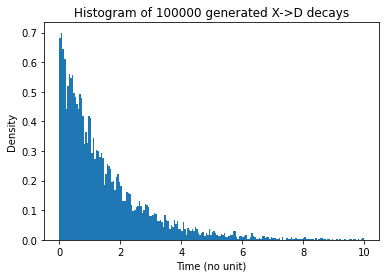

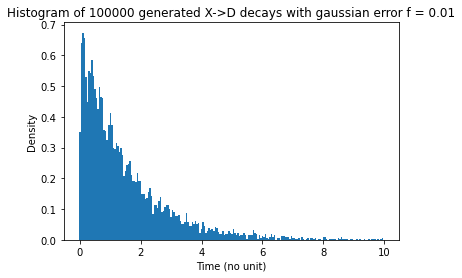

In [18]:
# Generate new data with our box_sim_gauss function, f = 0.01
pdf_list = box_sim_gauss(10000, tau, V, deltaM, 10)
pdf_list_noise = noise_adder(pdf_list, 0.01)
# plot histograms
plot_hist("Histogram of 100000 generated X->D decays", pdf_list)
plot_hist("Histogram of 100000 generated X->D decays with gaussian error f = 0.01", pdf_list_noise)


Fit using our previous NLL function and minuit onto this new data, and then onto the gaussian noise data

In [21]:
# Apply minuit and show results for normal data
o = minuit_process(nll_decay)
showIminuitResult(("tau","V","deltaM"), o)


	 tau             :  	   1.4659  +/-    0.0151
	 V               :  	   0.1227  +/-    0.0142
	 deltaM          :  	  20.1359  +/-    0.0545




In [22]:
# Apply minuit and show results for gaussian error data
# reset the pdf_list
pdf_list = pdf_list_noise
o_noise = minuit_process(nll_decay)
showIminuitResult(("tau","V","deltaM"), o_noise)


	 tau             :  	   1.4656  +/-    0.0151
	 V               :  	   0.1145  +/-    0.0142
	 deltaM          :  	  20.1259  +/-    0.0604




Printing results, then comparing with previous results from part 1 (10k events) to get the bias.

In [23]:
print("f = 0.01")
# {:.2} is significant digits (rounded to two)
print("KEY   -   Value Name : Value(Expected statistical precision/error)\n")

print("Statistical Errors for 100000 events without noise")
print("Lifetime parameter (Tau) : {:.6}({:.4})".format(o.values["tau"],o.errors["tau"]))
print("Matter/A-Matter asymm parameter (V) : {:.6}({:.4})".format(o.values["V"],o.errors["V"]))
print("Mass difference parameter (deltaM) : {:.6}({:.4})".format(o.values["deltaM"],o.errors["deltaM"]))
print("")
print("")

print("Statistical Errors for 100000 events with noise")
print("Lifetime parameter (Tau) : {:.6}({:.4})".format(o_noise.values["tau"],o_noise.errors["tau"]))
print("Matter/A-Matter asymm parameter (V) : {:.6}({:.4})".format(o_noise.values["V"],o_noise.errors["V"]))
print("Mass difference parameter (deltaM) : {:.6}({:.4})".format(o_noise.values["deltaM"],o_noise.errors["deltaM"]))
print("")
print("")
print("Bias produced by the gaussian error:")
# subtract the initial 10,000 event fit values from these new ones
print("Lifetime parameter bias (Tau) : {:.4}".format((o.values["tau"]-o_noise.values["tau"])))
print("Matter/A-Matter asymm parameter (V) : {:.4}".format((o.values["V"]-o_noise.values["V"])))
print("Mass difference parameter (deltaM) : {:.4}".format((o.values["deltaM"]-o_noise.values["deltaM"])))

f = 0.01
KEY   -   Value Name : Value(Expected statistical precision/error)

Statistical Errors for 100000 events without noise
Lifetime parameter (Tau) : 1.46591(0.01506)
Matter/A-Matter asymm parameter (V) : 0.122663(0.01416)
Mass difference parameter (deltaM) : 20.1359(0.05447)


Statistical Errors for 100000 events with noise
Lifetime parameter (Tau) : 1.46559(0.01506)
Matter/A-Matter asymm parameter (V) : 0.114475(0.01421)
Mass difference parameter (deltaM) : 20.1259(0.06044)


Bias produced by the gaussian error:
Lifetime parameter bias (Tau) : 0.0003167
Matter/A-Matter asymm parameter (V) : 0.008188
Mass difference parameter (deltaM) : 0.01003


So we can see here the bias produced due to the introduction of the gaussian error into our data production, but not our fitting. The bias produced here is very small, most likely due to the very small amount of gaussian noise we are adding. It is also more prevalent in the parameters V and $\Delta M$ which are characteristic of the sinusoidal component of the original function. This sinusoidal component is significantly 'blurred' in our data due to this noise and so I expect the next dataset to be even more biased away from the expected values. The bias is then demonstrated to be minimal when compared to the statistical errors for V and $\Delta M$.

Now onto f = 0.03, generating the new data:

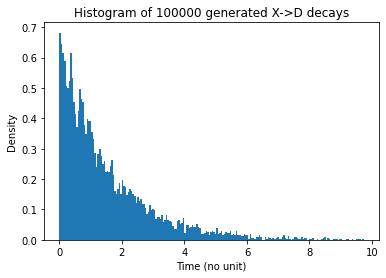

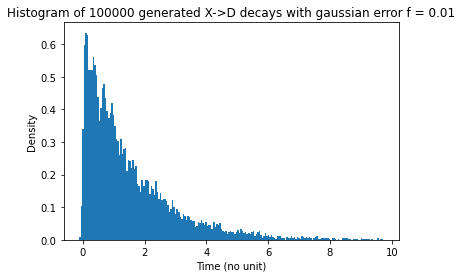

In [24]:
# Generate new data with our box_sim_gauss function, f = 0.03
pdf_list = box_sim_gauss(10000, tau, V, deltaM, 10)
pdf_list_noise = noise_adder(pdf_list, 0.03)
# plot histograms
plot_hist("Histogram of 100000 generated X->D decays", pdf_list)
plot_hist("Histogram of 100000 generated X->D decays with gaussian error f = 0.01", pdf_list_noise)



In [25]:
# Apply minuit and show results
p = minuit_process(nll_decay)
showIminuitResult(("tau","V","deltaM"), p)


	 tau             :  	   1.5178  +/-    0.0157
	 V               :  	   0.1073  +/-    0.0142
	 deltaM          :  	  20.0462  +/-    0.0640




In [26]:
# Apply minuit and show results for gaussian error data
# reset the pdf_list
pdf_list = pdf_list_noise
p_noise = minuit_process(nll_decay)
showIminuitResult(("tau","V","deltaM"), p_noise)


	 tau             :  	   1.5130  +/-    0.0156
	 V               :  	   0.0214  +/-    0.0141
	 deltaM          :  	  21.7276  +/-    0.2240




In [27]:
print("f = 0.03")
# {:.2} is significant digits (rounded to two)
print("KEY   -   Value Name : Value(Expected statistical precision/error)\n")

print("Statistical Errors for 100000 events without noise")
print("Lifetime parameter (Tau) : {:.6}({:.4})".format(p.values["tau"],p.errors["tau"]))
print("Matter/A-Matter asymm parameter (V) : {:.6}({:.4})".format(p.values["V"],p.errors["V"]))
print("Mass difference parameter (deltaM) : {:.6}({:.4})".format(p.values["deltaM"],p.errors["deltaM"]))
print("")
print("")

print("Statistical Errors for 100000 events with noise")
print("Lifetime parameter (Tau) : {:.6}({:.4})".format(p_noise.values["tau"],p_noise.errors["tau"]))
print("Matter/A-Matter asymm parameter (V) : {:.6}({:.4})".format(p_noise.values["V"],p_noise.errors["V"]))
print("Mass difference parameter (deltaM) : {:.6}({:.4})".format(p_noise.values["deltaM"],p_noise.errors["deltaM"]))
print("")
print("")
print("Bias produced by the gaussian error:")
# subtract the initial 10,000 event fit values from these new ones
print("Lifetime parameter bias (Tau) : {:.4}".format((p.values["tau"]-p_noise.values["tau"])))
print("Matter/A-Matter asymm parameter (V) : {:.4}".format((p.values["V"]-p_noise.values["V"])))
print("Mass difference parameter (deltaM) : {:.4}".format((p.values["deltaM"]-p_noise.values["deltaM"])))

f = 0.03
KEY   -   Value Name : Value(Expected statistical precision/error)

Statistical Errors for 100000 events without noise
Lifetime parameter (Tau) : 1.51778(0.01567)
Matter/A-Matter asymm parameter (V) : 0.1073(0.0142)
Mass difference parameter (deltaM) : 20.0462(0.06395)


Statistical Errors for 100000 events with noise
Lifetime parameter (Tau) : 1.51298(0.01561)
Matter/A-Matter asymm parameter (V) : 0.0214161(0.01414)
Mass difference parameter (deltaM) : 21.7276(0.224)


Bias produced by the gaussian error:
Lifetime parameter bias (Tau) : 0.004792
Matter/A-Matter asymm parameter (V) : 0.08588
Mass difference parameter (deltaM) : -1.681


Comparing these bias values to the ones from earlier, we can see that the tau bias is similar to previous values, and is significantly less than the statistical noise from our noisy fit. The V and $\Delta M$ bias on the otherhand are significantly larger than their statistical error, and this is reflected in the fact that they are significantly large in comparison to the statistical errors from the noisy fit.

Looking at the graph above, it is clear why this is the case. The V and $\Delta M$ parameters are defined by the sinusoidal components in the original function, and the gaussian noise almost wipes them out entirely, making it very difficult for our fitting process to determine their values with great accuracy.

Now to compile the data altogether (after some deprecated code)

In [30]:

# DEPRECATED CODE

# {:.2} is significant digits (rounded to two)
#print("Statistical Errors for 100000 events")
#print("KEY   -   Value Name : Value(Expected statistical precision/error)\n")
#print("Lifetime parameter (Tau) : {:.4}({:.2})".format(p.values["tau"],p.errors["tau"]))
#print("Matter/A-Matter asymm parameter (V) : {:.4}({:.2})".format(p.values["V"],p.errors["V"]))
#print("Mass difference parameter (deltaM) : {:.4}({:.2})".format(p.values["deltaM"],p.errors["deltaM"]))
#print("")
#print("Bias produced by the gaussian error:")
## subtract the initial 10,000 event fit errors from these new ones
#print("Lifetime parameter bias (Tau) : {:.4}".format(abs(p.values["tau"]-m.values["tau"])))
#print("Matter/A-Matter asymm parameter (V) : {:.4}".format(abs(p.errors["V"]-m.values["V"])))
#print("Mass difference parameter (deltaM) : {:.4}".format(abs(p.values["deltaM"]-m.values["deltaM"])))

And then lets compare biases from the 0.01 and 0.03 fractions:

In [31]:
print("FRACTION 0.01 BIAS RESULTS W/ ERRORS")
print("Lifetime parameter bias (Tau) : {:.4}".format((o.values["tau"]-o_noise.values["tau"])))
print("Matter/A-Matter asymm parameter (V) : {:.4}".format((o.values["V"]-o_noise.values["V"])))
print("Mass difference parameter (deltaM) : {:.4}".format((o.values["deltaM"]-o_noise.values["deltaM"])))
print("")
print("Statistical Errors")
print("Lifetime parameter (Tau) : ({:.2})".format(o_noise.errors["tau"]))
print("Matter/A-Matter asymm parameter (V) : ({:.2})".format(o_noise.errors["V"]))
print("Mass difference parameter (deltaM) : ({:.2})".format(o_noise.errors["deltaM"]))
print("")
print("")
print("FRACTION 0.03 BIAS RESULTS")
print("Lifetime parameter bias (Tau) : {:.4}".format((p.values["tau"]-p_noise.values["tau"])))
print("Matter/A-Matter asymm parameter (V) : {:.4}".format((p.values["V"]-p_noise.values["V"])))
print("Mass difference parameter (deltaM) : {:.4}".format((p.values["deltaM"]-p_noise.values["deltaM"])))
print("")
print("Statistical Errors")
print("Lifetime parameter (Tau) : ({:.2})".format(p_noise.errors["tau"]))
print("Matter/A-Matter asymm parameter (V) : ({:.2})".format(p_noise.errors["V"]))
print("Mass difference parameter (deltaM) : ({:.2})".format(p_noise.errors["deltaM"]))

FRACTION 0.01 BIAS RESULTS W/ ERRORS
Lifetime parameter bias (Tau) : 0.0002621
Matter/A-Matter asymm parameter (V) : 0.005244
Mass difference parameter (deltaM) : 0.003267

Statistical Errors
Lifetime parameter (Tau) : (0.015)
Matter/A-Matter asymm parameter (V) : (0.014)
Mass difference parameter (deltaM) : (0.061)


FRACTION 0.03 BIAS RESULTS
Lifetime parameter bias (Tau) : 0.001183
Matter/A-Matter asymm parameter (V) : 0.03473
Mass difference parameter (deltaM) : 0.1095

Statistical Errors
Lifetime parameter (Tau) : (0.016)
Matter/A-Matter asymm parameter (V) : (0.014)
Mass difference parameter (deltaM) : (0.14)


So as we can see here, as we increase the fraction of gaussian noise in our data, the bias increases for our M/AM and mass difference parameters. This is understandable considering the importance of the sinusoidal component of the PDF to their fitting. Even our Tau bias increases by a factor of 10, but this is still small when compared to the statistical error. The V and $\Delta M$ parameters are now significant in relation to their fit's statistical error, and so it is clear here that there is a relevant bias shifting our results from the nominal values.

But the data we generate is random by nature, so these biases will change on a run-by-run basis. So if we do many simulations of this same process and obtain the biases, we can determine an 'average bias' and a consequent error on the bias. This will be useful for solidifying our results further.

So, to make the process automatic, need to create little functional loops that will create new data, fit it and output the biases as we need them:

In [17]:
def collate_bias_components(pdf_list):
    mini = minuit_process(nll_decay)
    print(mini)

    errs = mini.errors
    vals = mini.values

    # data
    tau_list.append(vals["tau"])
    V_list.append(vals["V"])
    deltaM_list.append(vals["deltaM"])

    # errors
    tau_prec_list.append(errs["tau"])
    V_prec_list.append(errs["V"])
    deltaM_prec_list.append(errs["deltaM"])
    
    return tau_list, V_list, deltaM_list, tau_prec_list, V_prec_list, deltaM_prec_list

In [22]:
# Method for calculating bias average and its  
def bias_average(fraction, iterations):
    # create list for each parameter
    tau_list = []
    V_list = []
    deltaM_list = []
    tau_prec_list = []
    V_prec_list = []
    deltaM_prec_list =[]
    
    # create loop, 10000 events per each simulation
    for i in range(iterations):
        # collect date
        del pdf_list
        pdf_list = box_sim_gauss(10000, tau, V, deltaM, 10)
        pdf_list_noise = noise_adder(pdf_list, fraction)
        # fit and collect
        tau_list, V_list, deltaM_list, tau_prec_list, V_prec_list, deltaM_prec_list = collate_bias_components(pdf_list)    
    
    # Calculate the standard averages for these parameters and their errors
    tau_average = np.mean(tau_list)
    V_average = np.mean(V_list)
    deltaM_average = np.mean(deltaM_list)
    
    # standard averages of the statistical uncertainty (from minuit). Unsure whether to use this or not yet, but being calculated.
    tau_prec_average = np.mean(tau_prec_list)
    V_prec_average = np.mean(V_prec_list)
    deltaM_prec_average = np.mean(deltaM_prec_list)  
    
    # take standard error on these values, which will be used as standard error on our bias
    events_sqrt = np.sqrt(len(tau_list))
    tau_std = np.std(tau_list)/events_sqrt
    V_std = np.std(V_list)/events_sqrt
    deltaM_std = np.std(deltaM_list)/events_sqrt
    
    # calculate biases against average values from part 1 10,000 event run
    tau_bias = (tau_average - m.values["tau"])
    V_bias = (V_average - m.values["V"])
    deltaM_bias = (deltaM_average - m.values["deltaM"])
    
    # returning ALL the values, so that we can determine which ones are useful.
    return tau_average, V_average, deltaM_average, tau_bias, V_bias, deltaM_bias, tau_std,  V_std, deltaM_std, tau_prec_average, V_prec_average, deltaM_prec_average
    

    

### The function above didnt work, it appears to be because it decides to pull the pdf_list from a previous list rather than the one produced one line before, BUT if you try and remove this pdf_list from within the function it doesnt recognise it as existing.

This was clearly the same issue that I was experiencing in part 1. The sad and simple solution is that I need to pull the process out of the function, then it works perfectly. Be careful when running this next section of code as it will take a while.

Running 100 simulations for each of the 10k events, for each of the fractions and pulling out the bias and other relevant statistical information

In [23]:
# defining the print system first.
# lots of data...
# fully dependent on correct formatting in the next section, very obtuse to read but it works.

def print_bias_results(results):
    print("NO NOISE AVERAGE RESULTS:\n")
    print("TAU Value: {:.4}, Statistical Error: {:.4}, Standard Error: {:.4}\n".format(results[0][0], results[0][3], results[0][6]))
    print("V Value: {:.4}, Statistical Error: {:.4}, Standard Error: {:.4}\n".format(results[0][1], results[0][4], results[0][7]))
    print("deltaM Value: {:.4}, Statistical Error: {:.4}, Standard Error: {:.4}\n".format(results[0][2], results[0][5], results[0][8]))
    print("")
    print("")
    print("NOISE AVERAGE RESULTS:\n")
    print("TAU Value: {:.4}, Statistical Error: {:.4}, Standard Error: {:.4}\n".format(results[1][0], results[1][3], results[1][6]))
    print("V Value: {:.4}, Statistical Error: {:.4}, Standard Error: {:.4}\n".format(results[1][1], results[1][4], results[1][7]))
    print("deltaM Value: {:.4}, Statistical Error: {:.4},~ Standard Error: {:.4}\n".format(results[1][2], results[1][5], results[1][8]))
    print("")
    print("")
    print("BIAS AVERAGE RESULTS:\n")
    print("TAU bias: {:.4}, Standard Error: {:.4}".format(results[2][0],results[2][3]))
    print("V bias: {:.4}, Standard Error: {:.4}".format(results[2][1],results[2][4]))
    print("deltaM bias: {:.4}, Standard Error: {:.4}".format(results[2][2],results[2][5]))

## Be careful! this section runs the simulation 100 times for each fraction! So it will take a long time to run.

In [24]:
# defining the relavent lists beforehand
fractions = [0.01, 0.03]
simulation_runs = []
sim_titles = ["Fraction 0.01 Results:\n", "Fraction 0.03 Results:\n"]

# list of two fractions
for j in range(2):
    # create list for each parameter
    
    # biases
    tau_bias = []
    V_bias = []
    deltaM_bias = []
    
    # noiseless data
    tau_list = []
    V_list = []
    deltaM_list = []
    tau_prec_list = []
    V_prec_list = []
    deltaM_prec_list =[]
    
    # noisy data
    tau_list_noise = []
    V_list_noise = []
    deltaM_list_noise = []
    tau_prec_list_noise = []
    V_prec_list_noise = []
    deltaM_prec_list_noise =[]
    

    # create loop, 10000 events per each simulation, 100 sims for each
    for i in range(100):

        # generate the data, but only use noiseless data first
        pdf_list = box_sim_gauss(10000, tau, V, deltaM, 10)
        pdf_list_noise = noise_adder(pdf_list, fractions[j])
        # create minuit object and fit to original data
        mini = minuit_process(nll_decay)

        errs = mini.errors
        vals = mini.values

        # data
        tau_list.append(vals["tau"])
        V_list.append(vals["V"])
        deltaM_list.append(vals["deltaM"])

        # errors
        tau_prec_list.append(errs["tau"])
        V_prec_list.append(errs["V"])
        deltaM_prec_list.append(errs["deltaM"])
        
        # then add noise data and fit for that instead
        pdf_list = pdf_list_noise
        
        mini2 = minuit_process(nll_decay)
        
        errs2 = mini2.errors
        vals2 = mini2.values
        
        # data
        tau_list_noise.append(vals2["tau"])
        V_list_noise.append(vals2["V"])
        deltaM_list_noise.append(vals2["deltaM"])

        # errors
        tau_prec_list_noise.append(errs2["tau"])
        V_prec_list_noise.append(errs2["V"])
        deltaM_prec_list_noise.append(errs2["deltaM"])
        
        
        # calculate the systematic error and append to list
        tau_bias.append((tau_list[i]-tau_list_noise[i]))
        V_bias.append((V_list[i]-V_list_noise[i]))
        deltaM_bias.append((deltaM_list[i]-deltaM_list_noise[i]))
        
        # testing
        if (i%10==0):
            print(str(i) + "% complete")

    
    # RUN 1 -> NO NOISE
    
    # Calculate the standard averages for these parameters and their errors
    tau_average = np.mean(tau_list)
    V_average = np.mean(V_list)
    deltaM_average = np.mean(deltaM_list)

    # standard averages of the statistical uncertainty (from minuit). Unsure whether to use this or not yet, but being calculated.
    tau_prec_average = np.mean(tau_prec_list)
    V_prec_average = np.mean(V_prec_list)
    deltaM_prec_average = np.mean(deltaM_prec_list)  

    # take standard error on these values, which will be used as standard error on our bias
    events_sqrt = np.sqrt(len(tau_list))
    tau_std = np.std(tau_list)/events_sqrt
    V_std = np.std(V_list)/events_sqrt
    deltaM_std = np.std(deltaM_list)/events_sqrt

    
    
    
    # RUN 2 -> NOISE
    
    # Calculate the standard averages for these parameters and their errors
    tau_average_noise = np.mean(tau_list_noise)
    V_average_noise = np.mean(V_list_noise)
    deltaM_average_noise = np.mean(deltaM_list_noise)

    # standard averages of the statistical uncertainty (from minuit). Unsure whether to use this or not yet, but being calculated.
    tau_prec_average_noise = np.mean(tau_prec_list_noise)
    V_prec_average_noise = np.mean(V_prec_list_noise)
    deltaM_prec_average_noise = np.mean(deltaM_prec_list_noise)  

    # take standard error on these values, which will be used as standard error on our bias
    events_sqrt = np.sqrt(len(tau_list_noise))
    tau_std_noise = np.std(tau_list_noise)/events_sqrt
    V_std_noise = np.std(V_list_noise)/events_sqrt
    deltaM_std_noise = np.std(deltaM_list_noise)/events_sqrt
    
    
    
    
    
    # calculate biases against average values from part 1 10,000 event run
    tau_bias_average = np.mean(tau_bias)
    V_bias_average = np.mean(V_bias)
    deltaM_bias_average = np.mean(deltaM_bias)
    
    # take standard error on the bias values, which will be used as standard error on our bias
    events_sqrt = np.sqrt(len(tau_bias))
    tau_bias_std = np.std(tau_bias)/events_sqrt
    V_bias_std = np.std(V_bias)/events_sqrt
    deltaM_bias_std = np.std(deltaM_bias)/events_sqrt
    
    
    
    # save and print the data
    # format is RUN 1-> AVERAGES OF DATA: AVERAGES OF STATISTICAL ERRORS: STD OF DATA
    #           RUN 2-> AVERAGES OF NOISY DATA: AVERAGES OF NOISY STATISTICAL ERRORS: STD OF NOISY DATA
    #           BIAS AND STD OF BIAS
    data_run_1 = tau_average, V_average, deltaM_average, tau_prec_average, V_prec_average, deltaM_prec_average, tau_std,  V_std, deltaM_std
    data_run_2 = tau_average_noise, V_average_noise, deltaM_average_noise, tau_prec_average_noise, V_prec_average_noise, deltaM_prec_average_noise, tau_std_noise, V_std_noise, deltaM_std_noise
    data_bias = tau_bias_average, V_bias_average, deltaM_bias_average, tau_bias_std, V_bias_std, deltaM_bias_std
    
    # add to data list
    data = []
    data.append(data_run_1)
    data.append(data_run_2)
    data.append(data_bias)
    
    
    simulation_runs.append([data])
    
    print(sim_titles[j])
    print_bias_results(data)
    print("==========================")


0% complete
10% complete
20% complete


C:\Users\johnw\anaconda3\envs\daml\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
C:\Users\johnw\anaconda3\envs\daml\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


30% complete
40% complete
50% complete
60% complete
70% complete
80% complete
90% complete
Fraction 0.01 Results:

NO NOISE AVERAGE RESULTS:

TAU Value: 1.499, Statistical Error: 0.01545, Standard Error: 0.001462

V Value: 0.09442, Statistical Error: 0.01418, Standard Error: 0.002341

deltaM Value: 20.02, Statistical Error: 0.08833, Standard Error: 0.06317



NOISE AVERAGE RESULTS:

TAU Value: 1.498, Statistical Error: 0.01544, Standard Error: 0.001466

V Value: 0.08161, Statistical Error: 0.01451, Standard Error: 0.002882

deltaM Value: 19.85, Statistical Error: 0.2941,~ Standard Error: 0.1871



BIAS AVERAGE RESULTS:

TAU bias: 0.000621, Standard Error: 0.0001295
V bias: 0.01281, Standard Error: 0.002493
deltaM bias: 0.1684, Standard Error: 0.1811
0% complete
10% complete
20% complete
30% complete
40% complete
50% complete
60% complete
70% complete
80% complete
90% complete
Fraction 0.03 Results:

NO NOISE AVERAGE RESULTS:

TAU Value: 1.499, Statistical Error: 0.01546, Standard Error

So comparing our biases to one another, its clear that the V bias increases with larger gaussian noise, as our (f=0.03) bias are significantly larger than the (f=0.01) bias. Even so, the standard error on the bias is similar for both, which implies that there is a constant bias produced that is shifted further from the true value, but has a similar distribution for both fractions. For our $\Delta M$ biases, the bias averages stayed relatively consistent across both average runs, which makes sense as the $\Delta M$ defined the 'period' of our sinusoidal functions, and so even when scrambled, the period is still more likely to be fitted adequately. The V moreso controls the amplitude of our sinusoidal component and so this is harder to pick out when the data is scrambled by noise.

Comparing the bias results to the statistical errors for the noisy fits we can see that for the (f=0.01) run our tau bias is insignificant when compared to the statistical error (0.015>0.0007982), which isn't too surprising and is mirrored in the (f=0.03) section. This has been explained many times previously, as the tau being reliant on the exponential shape of the graph, rather than the sinusoidal components of the initial function makes the noise effect less significant for our fitting.

Our V bias for (f=0.01) is significant here, with it being larger than the statistical error, or within the same factor. This demonstrates how significant this bias is on our model fitting and how under-represented it is in the statistical error (would normally get systematic to produce a total error).

For (f=0.03), the significance of of our V bias is even greater, which is to be expected as the sinusoidal component of the function is further 'blurred' by our gaussian noise. This bias is once again significantly large when compared to the statistical error from the fitting, and are now significantly larger when compared to the (f=0.01) fitting.

The $\Delta M$ bias changes very little between runs and is less than the size of our statistical errors. It also has a significantly large standard error, which implies that there is a much larger spread in our deltaM values than the average bias, implying that the bias is not significant.

Even our tau bias increases, although only marginally, from (f=0.01) to (f=0.03)

So this demonstrates the importance of considering the bias in a dataset with unknown random noise, and compares our biases to their fit's statistical precision (which is understated in both of these cases).

One important thing to note in our results is that if you take the average value of the V fitting from (f=0.03) with noise and without, and subtract them from eachother, you'll see that it is smaller than our averaged V bias. This is because the noise is gaussian around our centre point (the "true value" for which it is trying to fit), but our bias is determined absolutely (negative -> positive), and so is significantly larger than the difference between the two average values, as they dont truly reflect the bias in our data.

## Part 3: Estimating a systematic error due to time acceptance

Measuring decay-time is thought to exhibit a decay-time acceptance of $a(t) = (1+st)$ with precision of $s = 0 \pm 0.03$.

Determine a suitable systematic error to assign to the measurement of each of the parameters due to this limited knowledge of a(t) and in each case compare this systematic error to the expected statistical precision.

This will be done with method 2 from lecture 11.

So we will generate 1 set of data with no noise and no time acceptance, and fit it with our PDF but with the decay-time acceptance function included, and many different values of s (within a gaussian distribution around $\pm$0.03). This should give a gaussian distribution of bias values for our parameters which we can then use to calculate a new systematic error.

So first, write new PDF and NLL

In [1]:
# define normalised probability density function

def decay_pdf_s(t, tau, V, deltaM, s):
    # not doing the full numerical integration here, will use scipy.integrate.quad
    func = lambda x: (1+V*np.sin(deltaM*x))*np.exp(-x/tau)*(1+s*x)
    norm = 1/(integrate.quad(func,0,10))[0]
    # apply normalisation to pdf and return it
    pdf_val = norm*func(t)
    return pdf_val

# NLL of above PDF with s inclusion

def nll_decay_s(tau, V, deltaM, s):
    
    # Take data, will need to define this before calling the function, which will be done if you run through the notebook linearly
    x = np.array(pdf_list)
    
    # calculate the pdf value, already normalised
    y = decay_pdf_s(x, tau, V, deltaM, s)
    
    # limit y so that is cant be zero here
    y = [10e-4 if y[i] <= 0 else y[i] for i in range(len(y))]
    
    # take log of y
    y_log = np.log(y)
    
    # take negative sum
    nll_sum = -np.sum(y_log)
    
    return nll_sum

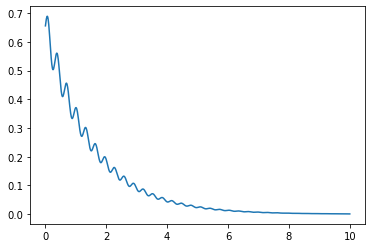

In [8]:
# Visualise the function (and to check its correct)
x_coord = np.linspace(0,10,num=1000)
y_coord = decay_pdf_s(x_coord, tau, V, deltaM, 0.01)

plt.plot(x_coord,y_coord)
plt.show()

So now we generate new data, and will fit it with respect to different values of s:

In [15]:
# Run sim with upperlimit of 10, to create a starter 'PDF' for the 
pdf_list = box_sim(10000, tau, V, deltaM, 10)

In [16]:
# Create a minuit fit for s = 0

s = 0
m = Minuit(nll_decay_s, tau = 1, V = 0.5, deltaM = 21, s = s)
# Set errors
m.errors = [1,1,2, 0.03]
# Define for NLL
m.errordef = 0.5
# Set limits
m.limits = [[0,3], [0,2], [10,30], [-0.5, 0.5]]

# fix s
m.fixed = [False, False, False, True]
# Fit and return fit
result_no_s = m.migrad()

print("s = 0 results\n")
showIminuitResult(("tau","V","deltaM"), m)
print("")

# Same again but with 0.03
s = 0.03
n = Minuit(nll_decay_s, tau = 1, V = 0.5, deltaM = 21, s = s)
# Set errors
n.errors = [1,1,2, 0.03]
# Define for NLL
n.errordef = 0.5
# Set limits
n.limits = [[0,3], [0,2], [10,30], [-0.5, 0.5]]

# fix s
n.fixed = [False, False, False, True]
# Fit and return fit
result_s = n.migrad()

print("s = 0.03 results\n")
showIminuitResult(("tau","V","deltaM"), n)





# Define s beforehand
#s = 0
#norm_fit = minuit_process(nll_decay_s)
#showIminuitResult(("tau","V","deltaM"), norm_fit)

# 1 sigma from s mean
#s = 0.03 
#time_fit = minuit_process(nll_decay_s)
#showIminuitResult(("tau","V","deltaM"), time_fit)

s = 0 results

	 tau             :  	   1.5190  +/-    0.0157
	 V               :  	   0.1216  +/-    0.0142
	 deltaM          :  	  19.9978  +/-    0.0503



s = 0.03 results

	 tau             :  	   1.4576  +/-    0.0145
	 V               :  	   0.1217  +/-    0.0142
	 deltaM          :  	  19.9977  +/-    0.0503




Now lets pull the bias out and the statistical errors:

In [17]:
print("Bias for parameters between s = 0 and s = 0.03")
print("")
print("Tau bias: {:.4}, Statistical error: {:.4}".format(result_no_s.values["tau"]-result_s.values["tau"],result_no_s.errors["tau"]))
print("V bias: {:.4}, Statistical error: {:.4}".format((result_no_s.values["V"]-result_s.values["V"]),result_no_s.errors["V"]))
print("deltaM bias: {:.4}, Statistical error: {:.4}".format((result_no_s.values["deltaM"]-result_s.values["deltaM"]),result_no_s.errors["deltaM"]))

Bias for parameters between s = 0 and s = 0.03

Tau bias: 0.06143, Statistical error: 0.01568
V bias: -9.684e-05, Statistical error: 0.01415
deltaM bias: 5.343e-05, Statistical error: 0.05029


So as we can see here, the only bias that is significant compared to the statistical error is the tau bias, which is to be expected, as the increase in s has an adverse effect on the exponential shape of the PDF as shown here:

Plotting with s=0

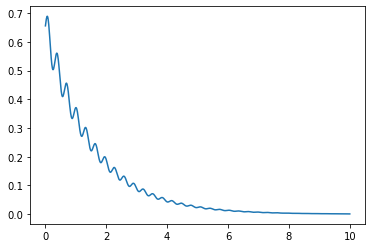

In [48]:
# Visualise the function (and to check its correct)
x_coord = np.linspace(0,10,num=1000)
y_coord = decay_pdf_s(x_coords, tau, V, deltaM, 0.01)

plt.plot(x_coord,y_coord)
plt.show()

Plotting with s=1

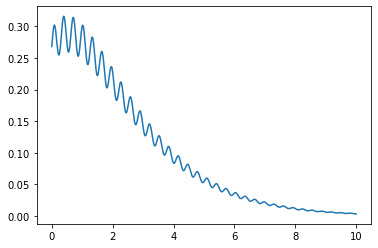

In [49]:
# Visualise the function (and to check its correct)
x_coord = np.linspace(0,10,num=1000)
y_coord = decay_pdf_s(x_coords, tau, V, deltaM, 1)

plt.plot(x_coord,y_coord)
plt.show()

As is clear here, the exponential shape of the graph is a affected by this change in s more so than the sinusoidal component of the PDF.

So now we'll be collecting s values across the a gaussian range using the error $\Delta s = 0.03$, and doing so 100 times and fitting these new pdfs to the data. Then we're taking the differences of these fits when compared to the initial (s=0) fit, and using those differences to determine the gaussian 'bias'. The width of which will give us our systematic error

In [50]:
# Generate new data
pdf_list = box_sim(10000, tau, V, deltaM, 10)

In [59]:
# Fit with s = 0 (original pdf)
s = 0
m = Minuit(nll_decay_s, tau = 1, V = 0.5, deltaM = 21, s = s)
# Set errors
m.errors = [1,1,2, 0.03]
# Define for NLL
m.errordef = 0.5
# Set limits
m.limits = [[0,3], [0,2], [10,30], [-0.5, 0.5]]

# fix s
m.fixed = [False, False, False, True]
# Fit and return fit
result_no_s = m.migrad()

tau_no_s = result_no_s.values["tau"]
V_no_s = result_no_s.values["V"]
deltaM_no_s = result_no_s.values["deltaM"]

tau_errors_no_s = result_no_s.errors["tau"]
V_errors_no_s = result_no_s.errors["V"]
deltaM_errors_no_s = result_no_s.errors["deltaM"]


# Create lists for the bias values
# Only taking the bias values here, will calculate standard error afterwards
tau_s = []
V_s = []
deltaM_s = []


# Create loop for the different s values, 100 simulations
for q in range(100):
    
    # determine s, then minimise with it.
    # reusing the gaussian function determined earlier
    s = gaussian(0, 0.03)
    
    n = Minuit(nll_decay_s, tau = 1, V = 0.5, deltaM = 21, s = s)
    # Set errors
    n.errors = [1,1,2, 0.03]
    # Define for NLL
    n.errordef = 0.5
    # Set limits
    n.limits = [[0,3], [0,2], [10,30], [-0.5, 0.5]]

    # fix s
    n.fixed = [False, False, False, True]
    # Fit and return fit
    result_s = n.migrad()
    
    tau_s.append(result_s.values["tau"])
    V_s.append(result_s.values["V"])
    deltaM_s.append(result_s.values["deltaM"])

# Calculate the systematic uncertainties
tau_s_bias = np.array(tau_s) - tau_no_s
V_s_bias = np.array(V_s) - V_no_s
deltaM_s_bias = np.array(deltaM_s) - deltaM_no_s
    
# Calculate average systematic error and std
tau_s_bias_average = np.average(tau_s_bias)
V_s_bias_average = np.average(V_s_bias)
deltaM_s_bias_average = np.average(deltaM_s_bias)

s_events = len(tau_s_bias)
tau_s_bias_stder = np.std(tau_s_bias)/np.sqrt(s_events)
V_s_bias_stder = np.std(V_s_bias)/np.sqrt(s_events)
deltaM_s_bias_stder = np.std(deltaM_s_bias)/np.sqrt(s_events)
    


In [52]:
# Plot the histograms of each
# defining the plotting function used throughout the code
def plot_hist_count(title, pdf_list):
    # Print histogram of pdf_list and describe the results
    plt.title(title)
    plt.xlabel("Offset from expected value")
    plt.ylabel("Counts")
    plt.hist(pdf_list, bins = 50, density = True)
    plt.show()


In [58]:
# Plot the results:

print("Systematic Uncertainty for parameters averaged across 100 runs")
print("")
print("Tau average bias: {:.4}, Statistical error of initial fit: {:.4}, Standard deviation on Bias: {:.4}".format(tau_s_bias_average, tau_errors_no_s,np.std(tau_s_bias)))
print("V average bias: {:.4}, Statistical error of initial fit: {:.4}, Standard deviation on Bias: {:.4}".format(V_s_bias_average, V_errors_no_s,np.std(V_s_bias)))
print("deltaM average bias: {:.4}, Statistical error of initial fit: {:.4}, Standard deviation on Bias: {:.4}".format(deltaM_s_bias_average, deltaM_errors_no_s, np.std(deltaM_s_bias)))

Systematic Uncertainty for parameters averaged across 100 runs

Tau average bias: 0.02292, Statistical error of initial fit: 0.01547, Standard deviation on Bias: 0.07818
V average bias: 0.0001478, Statistical error of initial fit: 0.01416, Standard deviation on Bias: 0.0003297
deltaM average bias: -8.942e-05, Statistical error of initial fit: 0.07075, Standard deviation on Bias: 0.0003188


And plot the gaussians of this average bias:

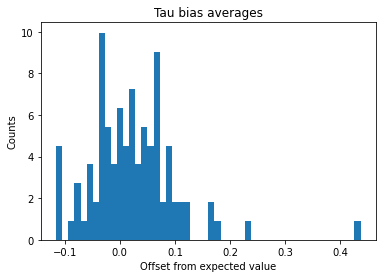

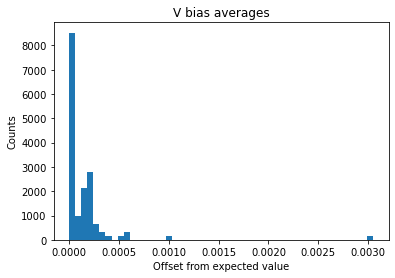

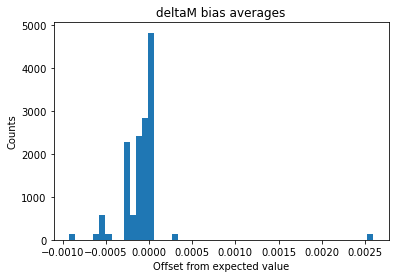

In [56]:
# Plot the distributions of the biases
plot_hist_count("Tau bias averages", tau_s_bias)    

plot_hist_count("V bias averages", V_s_bias)        

plot_hist_count("deltaM bias averages", deltaM_s_bias)        


So as we can see here, the tau systematic error for 100 runs is larger than the statistical error on our initial fit of the data. This demonstrates the need for a significant systematic error in our tau values, as our bias shifts are values for tau an average of 0.02 (in this run) in the positive direction, with much larger deviations possible. We should consider the standard deviation across our bias values, as this will give us the error on the bias itself and consequently provide a good value for our systematic error. In this run it is shown above as 0.07818, which is significantly larger than our average bias, but would ensure our tau value is within 3 $\sigma$ of the true value for most of our biased results. So I believe this value would be a good choice for our systematic error, which demonstrates that our systematic error is significantly larger than our statistical error (as can be seen on the printout above: 0.078 > 0.015)

For the V and deltaM values, this doesn't seem to be an issue, as the bias values are significantly smaller than the statistical errors, which suggests that the inclusion of (1+st) has had very little effect on the functions ability to fit them correctly. This is further demonstrated in the graphs above, as the biases give very skinny gaussians for our V and deltaM values

The V constantly being positive is peculiar, which as it implies that the V value is always overestimated. I'm not entirely sure why this is the case, as V defines the amplitude of the sine wave. There is most likely a reason for this, but I cannot find a conclusive reason for this to be the case.

## Graveyard of text
#### This is text from earlier. It has been added in for possible use later, but it will not be implemented in any significant way, and isnt worth reading.

Bias increases between the 0.01 -> 0.03 values, but the difference is a lot more significant for the V and $\Delta M$ bias, as these are more affected by the loss of information around the sinusoidal components of the PDFs.

Considering these biases with the minuit error shows for the tau values that the bias is significant in relation to the statistical error, and so would have to be considered when determining a total error.

For our V bias, minuit's statistical error is slightly larger than our bias for f(0.01) and smaller for f(0.03) across the averages. This demonstrates that the larger the noise, the more significant the bias is on our results and the harder minuit finds to fit it accurately (minuit error goes up by a factor of 5 between the runs).

For our $\Delta M$ value, the f(0.03) bias is larger by a factor of 10, which is still quite small considering that the true value of $\Delta M$ is 20 and we achieve 19.97 and 20.23 respectively. This still demonstrates that with more noise, our fitting model has more difficulty accurately matching the data and 

(found by taking the standard deviation of the averages, and dividing by the number of events) shows that the fitting is 